In [2]:
import warnings
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final.csv')
df

,Tournament,Club,Player,Number,Date,Market_value,Nation,Pos,Position,Age,...,Passes_through_balls,Passes_Switches,Passes_crosses,Passes_throw-Ins_taken,Corner_kicks,Corner_Kicks_In,Corner_Kicks_Out,Corner_Kicks_Straight,Passes_offside,Passes_blocked
0,Laliga,Ca Osasuna,Nano,23.0,2018-05-30,50000,es ESP,FW,Forward,25,...,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.0,0.100000,0.500000
1,Laliga,Rcd Mallorca,Alejandro Alfaro,32.0,2019-09-10,300000,es ESP,CM,Midfielder,20,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,Bundesliga,Bayer 04 Leverkusen,Paulinho,15.0,2022-11-09,7000000,br BRA,LM,Midfielder,29,...,0.058824,0.058824,0.088235,0.088235,0.000000,0.000000,0.000000,0.0,0.147059,0.500000
3,Premier League,Fc Liverpool,Fabinho,3.0,2022-11-03,55000000,br BRA,CM,Midfielder,28,...,0.122699,0.288344,0.239264,0.147239,0.000000,0.000000,0.000000,0.0,0.098160,0.472393
4,Serie A,Chievo Verona,Mamadou Samassa,30.0,2020-02-11,100000,ml MLI,GK,Goal Keeper,27,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.238095,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3480,Laliga,Real Sociedad San Sebastian,Robin Le Normand,24.0,2022-11-07,35000000,fr FRA,CB,Defender,25,...,0.008621,0.284483,0.025862,0.103448,0.000000,0.000000,0.000000,0.0,0.112069,0.224138
3481,Laliga,Real Sociedad San Sebastian,Ander Guevara,16.0,2022-11-07,5000000,es ESP,CB,Defender,25,...,0.059701,0.208955,0.074627,0.029851,0.000000,0.000000,0.000000,0.0,0.179104,0.567164
3482,Laliga,Fc Villarreal,Alfonso Pedraza,24.0,2022-11-07,18000000,es ESP,LB,Defender,26,...,0.025806,0.109677,2.909677,4.890323,0.006452,0.000000,0.006452,0.0,0.154839,1.716129
3483,Laliga,Real Sociedad San Sebastian,Jon Pacheco,20.0,2022-11-07,6000000,es ESP,CB,Defender,21,...,0.000000,0.285714,0.047619,0.238095,0.000000,0.000000,0.000000,0.0,0.190476,0.285714


In [5]:
forward = df[df['Position']=='Forward']
midfield = df[df['Position']=='Midfielder']
defence = df[df['Position']=='Defender']
gk = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final_gk.csv')

position_list = [forward,midfield,defence,gk]
# position_list


In [6]:
#Initiating a results Dataframe
lr_results = pd.DataFrame(columns=['Train/Test','Avg RMSE','Max RMSE','Min RMSE'])
a=1

for position in position_list:

    #Finding top 10 correlated features
    top_features = list((abs(position.corr()['Market_value'])).sort_values(ascending=False)[1:11].keys())

    #Separating target variable - 'Value'. Only top 10 features are included in X.
    X = position[top_features]
    y = position['Market_value']

    #Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

    ############################################################################

    #Making the distribution of the features more Gaussian

    pt = PowerTransformer()

    X_train_transformed = pt.fit_transform(X_train)
    X_test_transformed = pt.transform(X_test)


    #Scaling the data

    #Initiating Robust Scaler
    rs= RobustScaler()

    #Standardizing numerical columns
    X_train_scaled = rs.fit_transform(X_train_transformed)
    X_test_scaled = rs.transform(X_test_transformed)


    #Initiating the Linear Regressor
    lr = LinearRegression()

    #Fitting the Linear Regressor with Training Data
    lr.fit(X_train_scaled,y_train)


    cross_val_train = cross_val_score(lr, X_train_scaled, y_train, scoring="neg_root_mean_squared_error",cv=5)
    cross_val_test = cross_val_score(lr, X_test_scaled, y_test, scoring="neg_root_mean_squared_error",cv=5)


    #Train Results
    cross_val_train_mean = round(-(cross_val_train.mean()),2)
    cross_val_train_max = round(-(cross_val_train.min()),2)
    cross_val_train_min = round(-(cross_val_train.max()),2)

    #Test Results
    cross_val_test_mean = round(-(cross_val_test.mean()),2)
    cross_val_test_max = round(-(cross_val_test.min()),2)
    cross_val_test_min = round(-(cross_val_test.max()),2)

    #Appending Results to Dataframe and making Visuals
    
    if a == 1: 
        lr_results.loc[0] = ['Forward Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
        lr_results.loc[1] = ['Forward Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]

    if a == 2: 
        lr_results.loc[2] = ['Midfielder Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
        lr_results.loc[3] = ['Midfielder Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]
        
    if a == 3: 
        lr_results.loc[4] = ['Defender Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
        lr_results.loc[5] = ['Defender Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]
        
    if a == 4: 
        lr_results.loc[6] = ['Goalkeeper Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
        lr_results.loc[7] = ['Goalkeeper Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]

    a+=1

Text(0.5, 1.0, 'Linear Regression Average Results')

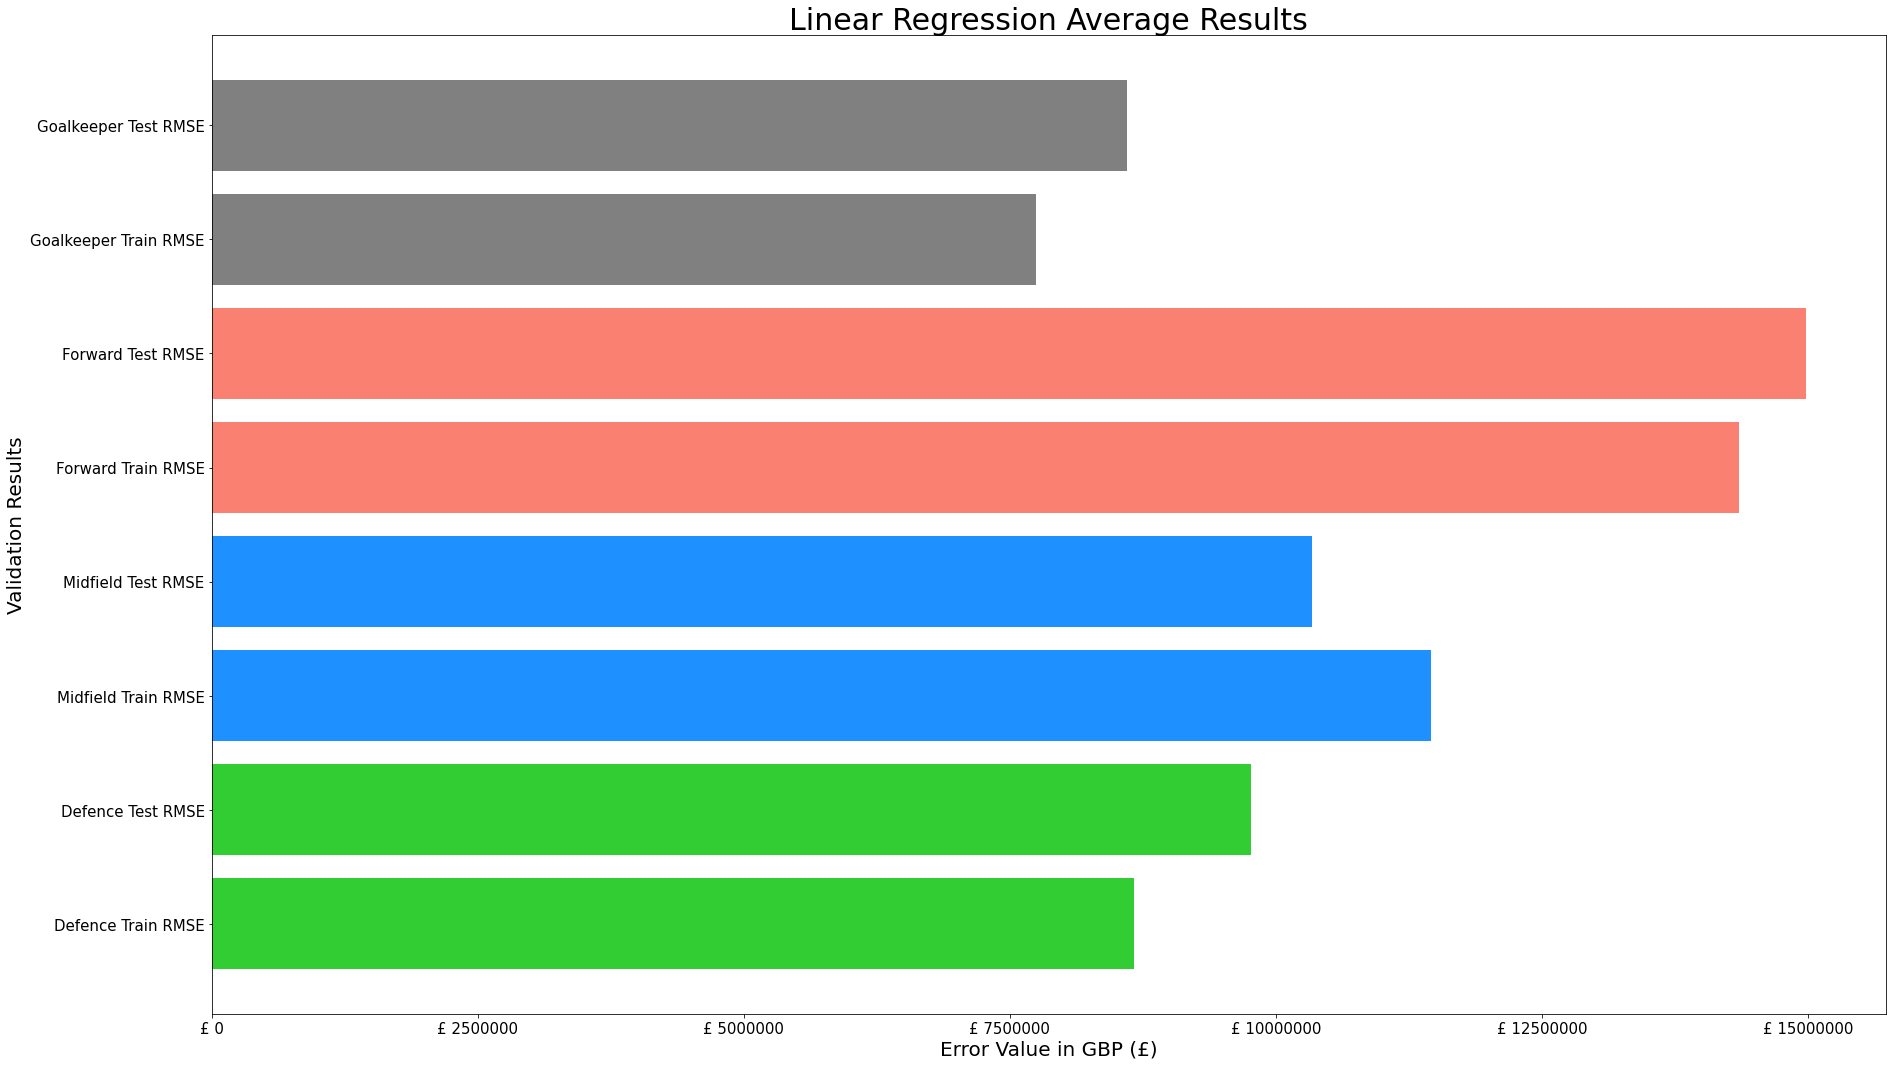

In [7]:
fig, ax = plt.subplots(figsize=(30,18))

x_ticks = list(range(0,int((max(lr_results['Avg RMSE']))+1000000),2500000))
y_ticks = [1,2,3,4,5,6,7,8]
y_labels = ['Defence Train RMSE','Defence Test RMSE',
            'Midfield Train RMSE','Midfield Test RMSE',
            'Forward Train RMSE','Forward Test RMSE',
            'Goalkeeper Train RMSE','Goalkeeper Test RMSE',]

#Goalkeeper Results
def_train_pos = 7
def_train = lr_results['Avg RMSE'][6]
ax.barh(def_train_pos,def_train,color='gray')

def_test_pos = 8
def_test = lr_results['Avg RMSE'][7]
ax.barh(def_test_pos,def_test,color='gray')

#Defence Results
def_train_pos = 1
def_train = lr_results['Avg RMSE'][4]
ax.barh(def_train_pos,def_train,color='limegreen')

def_test_pos = 2
def_test = lr_results['Avg RMSE'][5]
ax.barh(def_test_pos,def_test,color='limegreen')

#Midfield Results
mid_train_pos = 3
mid_train = lr_results['Avg RMSE'][2]
ax.barh(mid_train_pos,mid_train,color='dodgerblue')

mid_test_pos = 4
mid_test = lr_results['Avg RMSE'][3]
ax.barh(mid_test_pos,mid_test,color='dodgerblue')

#Forward Results
att_train_pos = 5
att_train = lr_results['Avg RMSE'][0]
ax.barh(att_train_pos,att_train,color='salmon')

att_test_pos = 6
att_test = lr_results['Avg RMSE'][1]
ax.barh(att_test_pos,att_test,color='salmon')


#Labels
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels,fontsize=15)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'£ {a}' for a in x_ticks],fontsize=15)
ax.set_xlabel('Error Value in GBP (£)',fontsize=20)
ax.set_ylabel('Validation Results',fontsize=20)
ax.set_title('Linear Regression Average Results',fontsize=30)

In [8]:
lr_results

,Train/Test,Avg RMSE,Max RMSE,Min RMSE
0,Forward Train,14347753.82,17678134.81,10558602.20
1,Forward Test,14980807.38,28860845.59,11132380.99
2,Midfielder Train,11452843.30,13325722.18,9945948.20
3,Midfielder Test,10342539.13,14437974.08,7929340.26
4,Defender Train,8667686.63,10097902.62,7385880.28
5,Defender Test,9766774.82,12347302.02,6418935.20
6,Goalkeeper Train,7746932.08,8534457.51,6704810.10
7,Goalkeeper Test,8602024.07,13682352.68,5107819.56


In [9]:
#Initiating a results Dataframe
l1_results = pd.DataFrame(columns=['Train/Test','Avg RMSE','Max RMSE','Min RMSE'])
a=1
warnings.filterwarnings("ignore")
for position in position_list:

    #Finding top 10 correlated features
    top_features = list((abs(position.corr()['Market_value'])).sort_values(ascending=False)[1:11].keys())

    #Separating target variable - 'Value'. Only top 10 features are included in X.
    X = position[top_features]
    y = position['Market_value']

    #Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

    ############################################################################

    #Making the distribution of the features more Gaussian

    pt = PowerTransformer()

    X_train_transformed = pt.fit_transform(X_train)
    X_test_transformed = pt.transform(X_test)

    ############################################################################

    #Scaling the data

    #Initiating Robust Scaler
    rs= RobustScaler()

    #Standardizing numerical columns
    X_train_scaled = rs.fit_transform(X_train_transformed)
    X_test_scaled = rs.transform(X_test_transformed)

    ############################################################################

    #Initiating the Linear Regressor
    l1 = Lasso()

    #Fitting the Linear Regressor with Training Data
    l1.fit(X_train_scaled,y_train)

    ############################################################################

    cross_val_train = cross_val_score(l1, X_train_scaled, y_train, scoring="neg_root_mean_squared_error",cv=5)
    cross_val_test = cross_val_score(l1, X_test_scaled, y_test, scoring="neg_root_mean_squared_error",cv=5)

    ############################################################################

    #Train Results
    cross_val_train_mean = round(-(cross_val_train.mean()),2)
    cross_val_train_max = round(-(cross_val_train.min()),2)
    cross_val_train_min = round(-(cross_val_train.max()),2)

    #Test Results
    cross_val_test_mean = round(-(cross_val_test.mean()),2)
    cross_val_test_max = round(-(cross_val_test.min()),2)
    cross_val_test_min = round(-(cross_val_test.max()),2)

    #Appending Results to Dataframe and making Visuals
    
    if a == 1: 
        l1_results.loc[0] = ['Forward Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
        l1_results.loc[1] = ['Forward Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]

    if a == 2: 
        l1_results.loc[2] = ['Midfield Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
        l1_results.loc[3] = ['Midfield Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]
        
    if a == 3: 
        l1_results.loc[4] = ['Defend Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
        l1_results.loc[5] = ['Defend Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]
        
    if a == 4: 
        l1_results.loc[6] = ['Goalkeeper Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
        l1_results.loc[7] = ['Goalkeeper Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]

    a+=1

Text(0.5, 1.0, 'Lasso Regression Average Results')

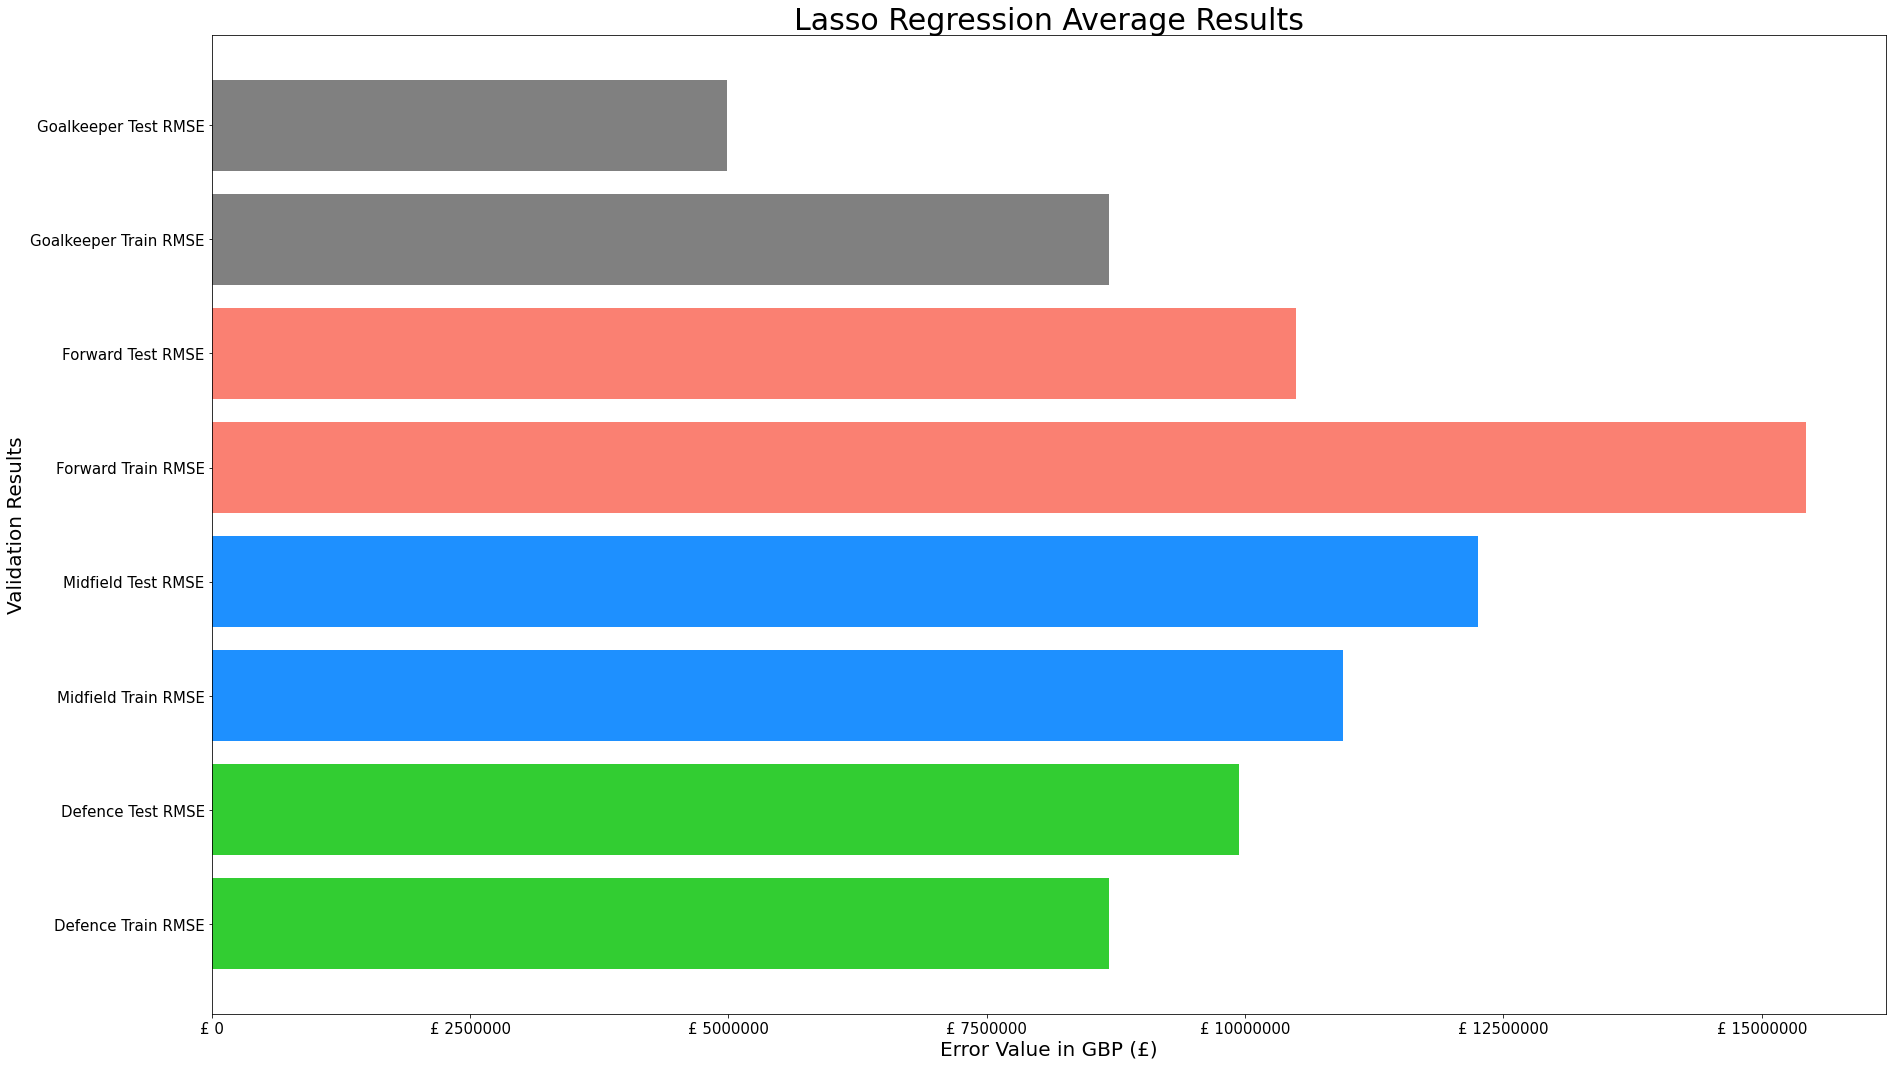

In [10]:
fig, ax = plt.subplots(figsize=(30,18))

x_ticks = list(range(0,int((max(l1_results['Avg RMSE']))+1000000),2500000))
y_ticks = [1,2,3,4,5,6,7,8]
y_labels = ['Defence Train RMSE','Defence Test RMSE',
            'Midfield Train RMSE','Midfield Test RMSE',
            'Forward Train RMSE','Forward Test RMSE',
            'Goalkeeper Train RMSE','Goalkeeper Test RMSE',]

#Defence Results
def_train_pos = 1
def_train = l1_results['Avg RMSE'][4]
ax.barh(def_train_pos,def_train,color='limegreen')

def_test_pos = 2
def_test = l1_results['Avg RMSE'][5]
ax.barh(def_test_pos,def_test,color='limegreen')

#Midfield Results
mid_train_pos = 3
mid_train = l1_results['Avg RMSE'][2]
ax.barh(mid_train_pos,mid_train,color='dodgerblue')

mid_test_pos = 4
mid_test = l1_results['Avg RMSE'][3]
ax.barh(mid_test_pos,mid_test,color='dodgerblue')

#Forward Results
att_train_pos = 5
att_train = l1_results['Avg RMSE'][0]
ax.barh(att_train_pos,att_train,color='salmon')

att_test_pos = 6
att_test = l1_results['Avg RMSE'][1]
ax.barh(att_test_pos,att_test,color='salmon')

#Goalkeeper Results
def_train_pos = 7
def_train = l1_results['Avg RMSE'][6]
ax.barh(def_train_pos,def_train,color='gray')

def_test_pos = 8
def_test = l1_results['Avg RMSE'][7]
ax.barh(def_test_pos,def_test,color='gray')


#Labels
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels,fontsize=15)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'£ {a}' for a in x_ticks],fontsize=15)
ax.set_xlabel('Error Value in GBP (£)',fontsize=20)
ax.set_ylabel('Validation Results',fontsize=20)
ax.set_title('Lasso Regression Average Results',fontsize=30)

In [11]:
l1_results


,Train/Test,Avg RMSE,Max RMSE,Min RMSE
0,Forward Train,15428341.54,21645857.27,12726333.77
1,Forward Test,10493516.44,13400543.41,8210715.32
2,Midfield Train,10945073.00,11564814.62,9767545.97
3,Midfield Test,12250607.29,16972436.76,8292304.56
4,Defend Train,8679333.36,10841844.37,6426455.41
5,Defend Test,9945605.14,13175875.03,7014909.14
6,Goalkeeper Train,8686686.28,10913477.14,6591575.40
7,Goalkeeper Test,4984460.71,8333810.47,2841136.30


In [12]:
#Initiating a results Dataframe
l2_results = pd.DataFrame(columns=['Train/Test','Avg RMSE','Max RMSE','Min RMSE'])
a=1
warnings.filterwarnings("ignore")
for position in position_list:

    #Finding top 10 correlated features
    top_features = list((abs(position.corr()['Market_value'])).sort_values(ascending=False)[1:11].keys())

    #Separating target variable - 'Value'. Only top 10 features are included in X.
    X = position[top_features]
    y = position['Market_value']

    #Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

    ############################################################################

    #Making the distribution of the features more Gaussian

    pt = PowerTransformer()

    X_train_transformed = pt.fit_transform(X_train)
    X_test_transformed = pt.transform(X_test)

    ############################################################################

    #Scaling the data

    #Initiating Robust Scaler
    rs= RobustScaler()

    #Standardizing numerical columns
    X_train_scaled = rs.fit_transform(X_train_transformed)
    X_test_scaled = rs.transform(X_test_transformed)

    ############################################################################

    #Initiating the Linear Regressor
    l2 = Ridge()

    #Fitting the Linear Regressor with Training Data
    l2.fit(X_train_scaled,y_train)

    ############################################################################

    cross_val_train = cross_val_score(l2, X_train_scaled, y_train, scoring="neg_root_mean_squared_error",cv=5)
    cross_val_test = cross_val_score(l2, X_test_scaled, y_test, scoring="neg_root_mean_squared_error",cv=5)

    ############################################################################

    #Train Results
    cross_val_train_mean = round(-(cross_val_train.mean()),2)
    cross_val_train_max = round(-(cross_val_train.min()),2)
    cross_val_train_min = round(-(cross_val_train.max()),2)

    #Test Results
    cross_val_test_mean = round(-(cross_val_test.mean()),2)
    cross_val_test_max = round(-(cross_val_test.min()),2)
    cross_val_test_min = round(-(cross_val_test.max()),2)

    #Appending Results to Dataframe and making Visuals
    
    if a == 1: 
        l2_results.loc[0] = ['Forward Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
        l2_results.loc[1] = ['Forward Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]

    if a == 2: 
        l2_results.loc[2] = ['Midfield Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
        l2_results.loc[3] = ['Midfield Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]
        
    if a == 3: 
        l2_results.loc[4] = ['Defend Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
        l2_results.loc[5] = ['Defend Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]
        
    if a == 4: 
        l2_results.loc[6] = ['Goalkeeper Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
        l2_results.loc[7] = ['Goalkeeper Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]

    a+=1

Text(0.5, 1.0, 'Ridge Regression Average Results')

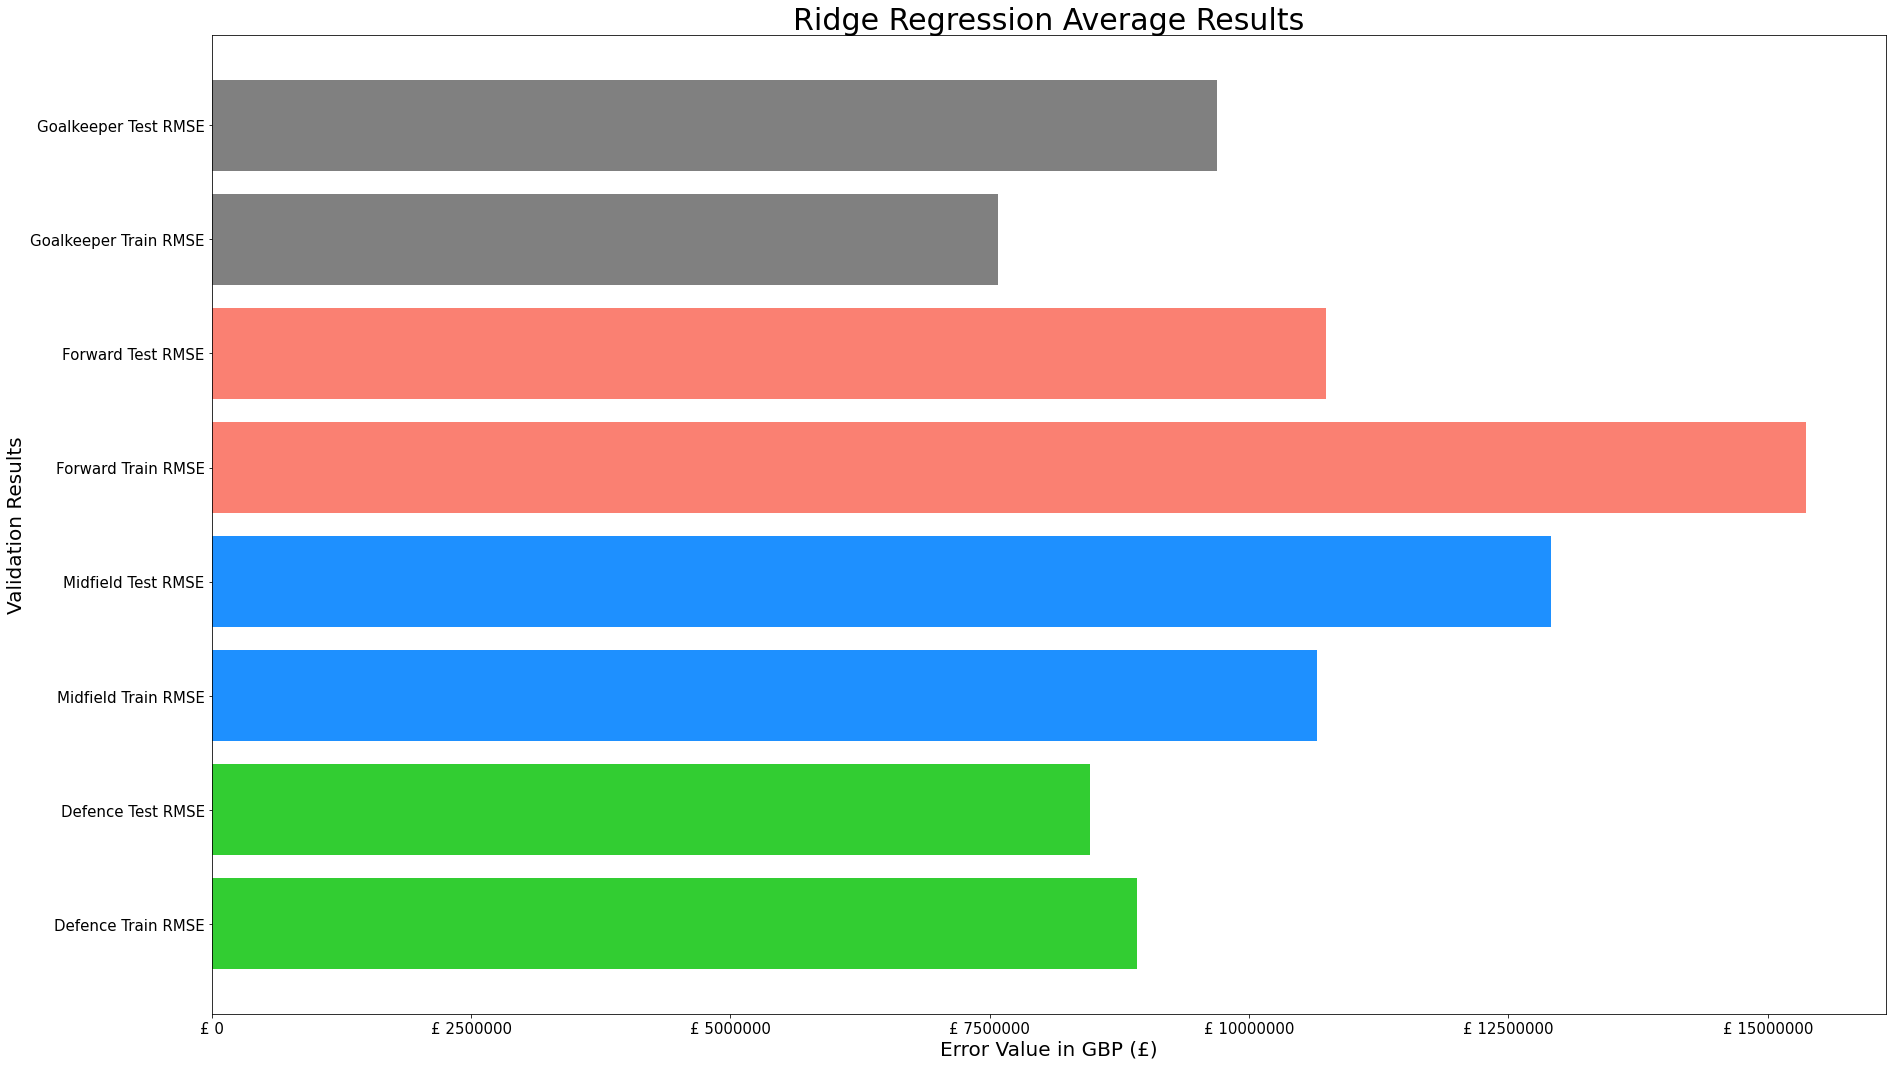

In [13]:
fig, ax = plt.subplots(figsize=(30,18))

x_ticks = list(range(0,int((max(l2_results['Avg RMSE']))+1000000),2500000))
y_ticks = [1,2,3,4,5,6,7,8]
y_labels = ['Defence Train RMSE','Defence Test RMSE',
            'Midfield Train RMSE','Midfield Test RMSE',
            'Forward Train RMSE','Forward Test RMSE',
            'Goalkeeper Train RMSE','Goalkeeper Test RMSE',]

#Defence Results
def_train_pos = 1
def_train = l2_results['Avg RMSE'][4]
ax.barh(def_train_pos,def_train,color='limegreen')

def_test_pos = 2
def_test = l2_results['Avg RMSE'][5]
ax.barh(def_test_pos,def_test,color='limegreen')

#Midfield Results
mid_train_pos = 3
mid_train = l2_results['Avg RMSE'][2]
ax.barh(mid_train_pos,mid_train,color='dodgerblue')

mid_test_pos = 4
mid_test = l2_results['Avg RMSE'][3]
ax.barh(mid_test_pos,mid_test,color='dodgerblue')

#Forward Results
att_train_pos = 5
att_train = l2_results['Avg RMSE'][0]
ax.barh(att_train_pos,att_train,color='salmon')

att_test_pos = 6
att_test = l2_results['Avg RMSE'][1]
ax.barh(att_test_pos,att_test,color='salmon')

#Goalkeeper Results
def_train_pos = 7
def_train = l2_results['Avg RMSE'][6]
ax.barh(def_train_pos,def_train,color='gray')

def_test_pos = 8
def_test = l2_results['Avg RMSE'][7]
ax.barh(def_test_pos,def_test,color='gray')


#Labels
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels,fontsize=15)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'£ {a}' for a in x_ticks],fontsize=15)
ax.set_xlabel('Error Value in GBP (£)',fontsize=20)
ax.set_ylabel('Validation Results',fontsize=20)
ax.set_title('Ridge Regression Average Results',fontsize=30)

In [14]:
l2_results

,Train/Test,Avg RMSE,Max RMSE,Min RMSE
0,Forward Train,15368430.44,18389600.61,11880089.72
1,Forward Test,10745026.19,14419821.81,6060854.94
2,Midfield Train,10656649.22,12604524.42,7814914.19
3,Midfield Test,12906262.23,16323976.49,9410381.78
4,Defend Train,8919524.74,10477256.97,7578139.13
5,Defend Test,8470625.52,11337896.75,5864274.15
6,Goalkeeper Train,7575531.85,10922077.70,5183065.41
7,Goalkeeper Test,9692388.93,12269319.33,7630736.90


Text(0.5, 1.0, 'Linear/Lasso/Ridge Regression Average Test RMSEs')

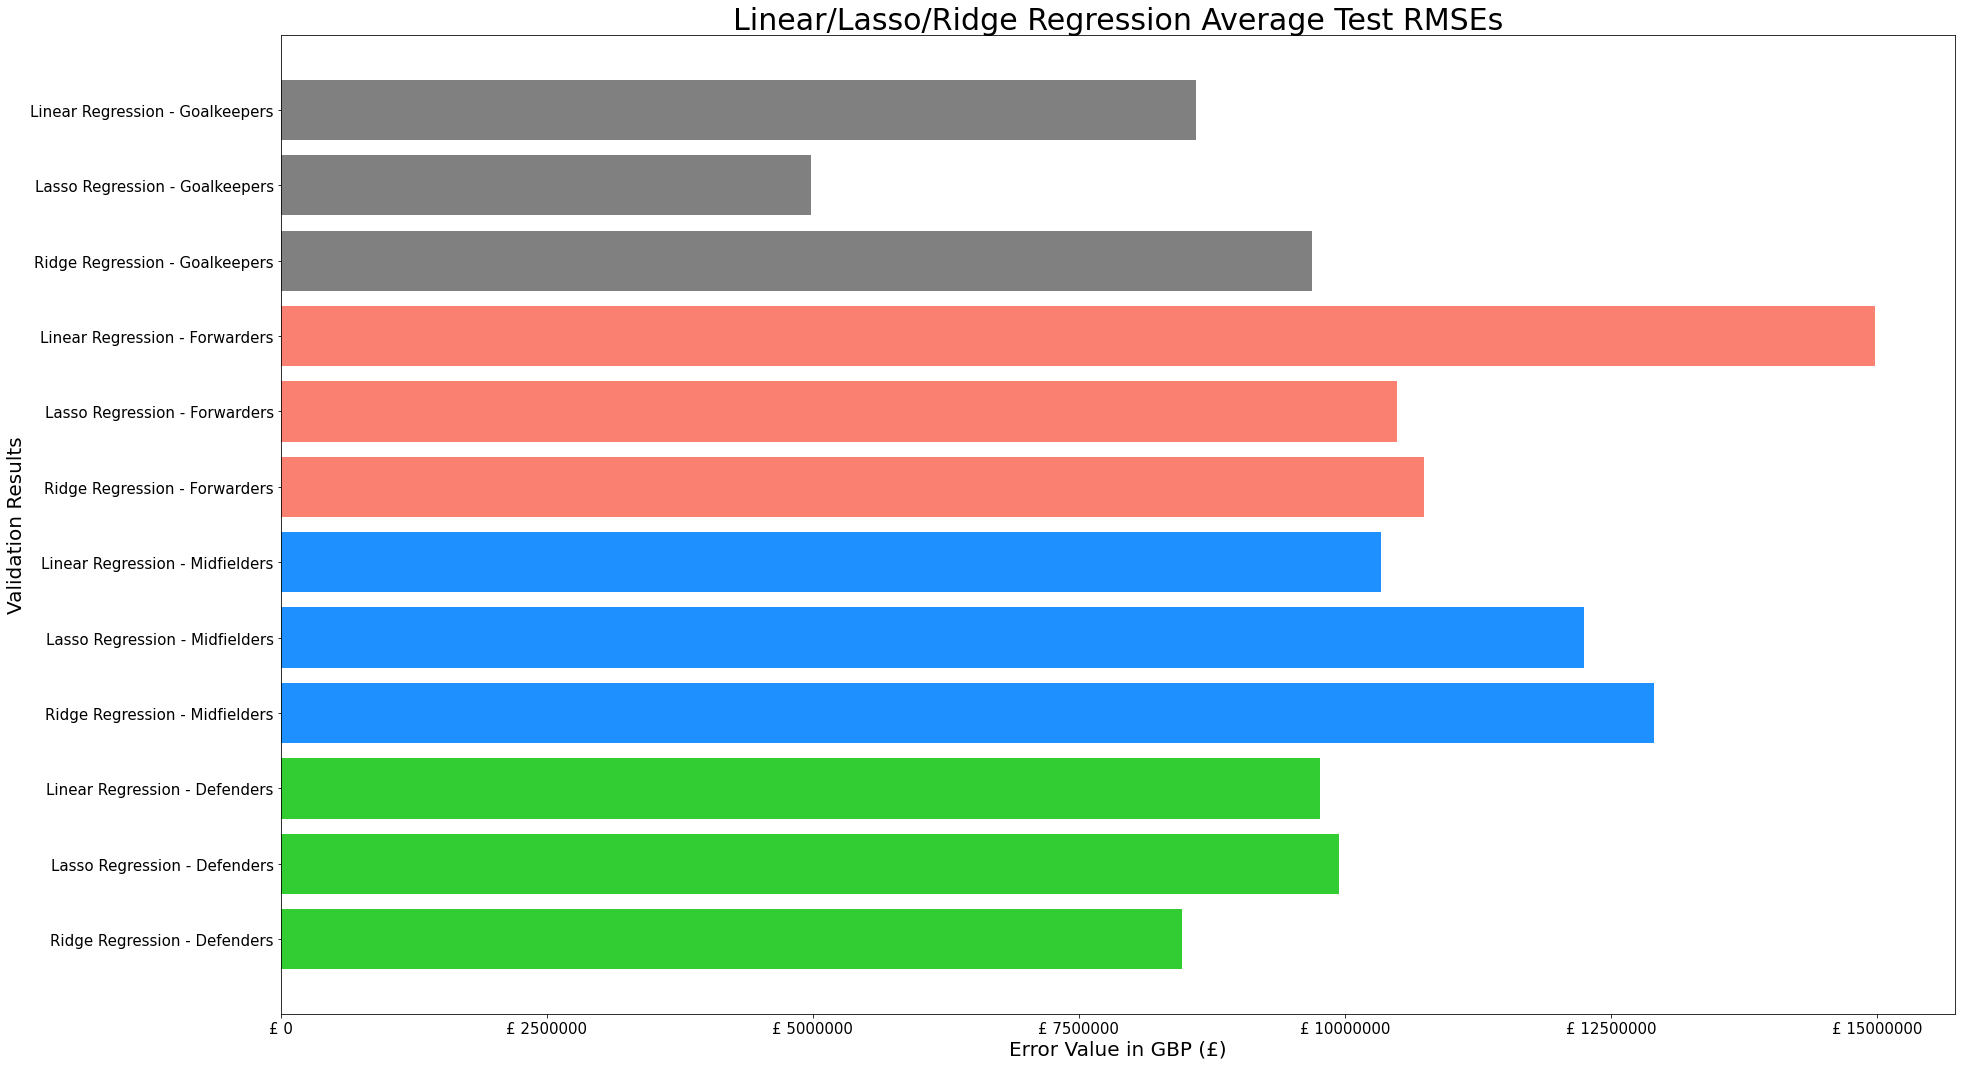

In [15]:
fig, ax = plt.subplots(figsize=(30,18))

x_ticks = list(range(0,int((max(l2_results['Avg RMSE']))+1000000),2500000))
y_ticks = list(range(1,13))
y_labels = ['Ridge Regression - Defenders',
            'Lasso Regression - Defenders',
            'Linear Regression - Defenders',
            'Ridge Regression - Midfielders',
            'Lasso Regression - Midfielders', 
            'Linear Regression - Midfielders',
            'Ridge Regression - Forwarders',
            'Lasso Regression - Forwarders',
            'Linear Regression - Forwarders',
            'Ridge Regression - Goalkeepers',
            'Lasso Regression - Goalkeepers',
            'Linear Regression - Goalkeepers']

#Defence Results
l2_def_test_pos = 1
l2_def_test = l2_results['Avg RMSE'][5]
ax.barh(l2_def_test_pos,l2_def_test,color='limegreen')

l1_def_test_pos = 2
l1_def_test = l1_results['Avg RMSE'][5]
ax.barh(l1_def_test_pos,l1_def_test,color='limegreen')

lr_def_test_pos = 3
lr_def_test = lr_results['Avg RMSE'][5]
ax.barh(lr_def_test_pos,lr_def_test,color='limegreen')

#Midfield Results
l2_mid_test_pos = 4
l2_mid_test = l2_results['Avg RMSE'][3]
ax.barh(l2_mid_test_pos,l2_mid_test,color='dodgerblue')

l1_mid_test_pos = 5
l1_mid_test = l1_results['Avg RMSE'][3]
ax.barh(l1_mid_test_pos,l1_mid_test,color='dodgerblue')

lr_mid_test_pos = 6
lr_mid_test = lr_results['Avg RMSE'][3]
ax.barh(lr_mid_test_pos,lr_mid_test,color='dodgerblue')

#Forward Results

l2_att_test_pos = 7
l2_att_test = l2_results['Avg RMSE'][1]
ax.barh(l2_att_test_pos,l2_att_test,color='salmon')

l1_att_test_pos = 8
l1_att_test = l1_results['Avg RMSE'][1]
ax.barh(l1_att_test_pos,l1_att_test,color='salmon')

lr_att_test_pos = 9
lr_att_test = lr_results['Avg RMSE'][1]
ax.barh(lr_att_test_pos,lr_att_test,color='salmon')

#Goalkeeper Results

l2_att_test_pos = 10
l2_att_test = l2_results['Avg RMSE'][7]
ax.barh(l2_att_test_pos,l2_att_test,color='grey')

l1_att_test_pos = 11
l1_att_test = l1_results['Avg RMSE'][7]
ax.barh(l1_att_test_pos,l1_att_test,color='grey')

lr_att_test_pos = 12
lr_att_test = lr_results['Avg RMSE'][7]
ax.barh(lr_att_test_pos,lr_att_test,color='grey')

#Labels
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels,fontsize=15)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'£ {a}' for a in x_ticks],fontsize=15)
ax.set_xlabel('Error Value in GBP (£)',fontsize=20)
ax.set_ylabel('Validation Results',fontsize=20)
ax.set_title('Linear/Lasso/Ridge Regression Average Test RMSEs',fontsize=30)